# Introduction



# Steps
1- Realease the particles (2_PT_seseflux)

2- Read the particles for each month 

3- Reduce to first particles intersection to coastline, delete the ones that does not interact with coastline 

4- Make a dataframe that only include the particles first intersect with the shoreline for each month 

-(another thing we need to add is to add a group_number to the particles in addition that group_id like 11, 12, 13, code 3)

# Import required Libraries

In [1]:
# Standard libraries
import os
import glob
import warnings
import gc

# Data manipulation and analysis libraries
import numpy as np
import pandas as pd
import dask.dataframe as dd
import xarray as xr
import geopandas as gpd
from shapely.geometry import Point
from netCDF4 import Dataset

# Dask diagnostics and progress bar
from dask.diagnostics import ProgressBar

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import cartopy.crs as ccrs
from pylag.processing.plot import FVCOMPlotter, create_figure, colourmap

# Helper Functions

In [7]:
def sort_key(file):
    filename = os.path.basename(file)
    number = int(filename.split('__')[1].split('.')[0])
    return number

# Inputs

In [ ]:
# Define paths for coastal wetland shapefiles
GIS_LAYERS = '/home/abolmaal/Data/GIS_layer'  # Add leading slash to make it an absolute path
CW_path = os.path.join(GIS_LAYERS, 'Coastalwetland/hitshoreline')

#CW_path = '/mnt/d/Users/abolmaal/Arcgis/NASAOceanProject/GIS_layer/Coastalwetland/hitshoreline/'

# Paths to specific coastal wetland shapefiles with different inundation levels that have 50 meter buffer from the shoreline
CW_avg_path = os.path.join(CW_path, 'Wetland_connected_avg_inundation_NAD1sna983_shorelineinteraction_50m_ExportFeatures.shp')
CW_low_path = os.path.join(CW_path, 'wetlands_connected_low_inundation_NAD1983_shorelineinteraction_50m_ExportFeatures.shp')
CW_high_path = os.path.join(CW_path, 'wetlands_connected_high_inundation_NAD1983_shorelineinteraction_50m_ExportFeatures.shp')
CW_surge_path = os.path.join(CW_path, 'wetlands_connected_surge_inundation_NAD1983_shorelineinteraction_50m_ExportFeatures.shp')

# Load coastal wetland shapefiles as GeoDataFrames
CW_avg = gpd.read_file(CW_avg_path)
CW_low = gpd.read_file(CW_low_path)
CW_high = gpd.read_file(CW_high_path)
CW_surge = gpd.read_file(CW_surge_path)

# Define the path to FVCOM model output files
data_dir = '/home/abolmaal/modelling/FVCOM/Huron/output/monthly_output'
files = glob.glob(os.path.join(data_dir, "updated_Fvcome_huron_estuary_2023_Winter_*.nc"))
files.sort(key=sort_key)

# Open multiple NetCDF datasets with xarray, using chunks and parallel processing
datasets = xr.open_mfdataset(files, combine='by_coords', parallel=True)

# Define the path to the FVCOM grid metrics file
grid_metrics_file_name = '/home/abolmaal/modelling/FVCOM/Huron/input/gridfile/grid_metrics_huron_senseflux_Seasonal.nc'



# Path to nutrient load data CSV and load the CSV
Direct_Nutrient_load = '/mnt/d/Users/abolmaal/Arcgis/NASAOceanProject/ZonalStats/StreamWatresheds_total_N_P.csv'
Direct_Nutrient = pd.read_csv(Direct_Nutrient_load)

# Check and rename columns in the CSV file to match NetCDF data requirements
required_columns = {'Group_id': 'group_id', 'WetLoad_TN_kgcellday': 'WetLoad_TN_kgcellday', 'WetLoad_TP_kgcellday': 'WetLoad_TP_kgcellday'}

for col, new_col in required_columns.items():
    if col not in Direct_Nutrient.columns:
        raise ValueError(f"CSV file is missing required column: '{col}'")
Direct_Nutrient.rename(columns={'Group_id': 'group_id'}, inplace=True)


# Output

In [10]:
output_path = '/home/abolmaal/modelling/FVCOM/Huron/results'

# Define the file names to the FVCOM model output
originalFVCOM = 'LakeHuronparticletracking_2023_original.shp'


# file name for Intersected FVCOM model output with coastal wetlands

Intersection_PTCW_Avg = 'Intersections_Avg_PTCW.csv'
Intersection_PTCW_high = 'Intersections_high_PTCW.csv'
Intersection_PTCW_low = 'Intersections_low_PTCW.csv'
Intersection_PTCW_surge = 'Intersections_surge_PTCW.csv'
###################################################################
GroupIdcount = 'group_id_counts.csv'
Non_Intersection_avg = 'Non_Intersection_avg.csv'
Non_Intersection_high = 'Non_Intersection_high.csv'
Non_Intersection_low = 'Non_Intersection_low.csv'
Non_Intersection_surge = 'Non_Intersection_surge.csv'


# Parameters

### Figure Parameters

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm

# Figure parameters
# Custom colormap setup (pink and blue shades)
pink_shades = ['#fff5f7', '#ffebf0', '#ffd6e1', '#ffbfd4', '#ff99c1', '#ff6ea9', '#ff4c92', '#ff2171', '#b50d4e']
blue_shades = ['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#084594']
blue_shades_reversed = blue_shades[::-1]

pink_cmap = LinearSegmentedColormap.from_list('custom_pink', pink_shades)
blue_cmap_reversed = LinearSegmentedColormap.from_list('custom_blue', blue_shades)

# Define a list of green shades for the colormap
green_shades =  ['#e0ffe0', '#b3ffb3', '#80ff80', '#4dff4d', '#00e600', '#00cc00', '#009900', '#006600', '#003300']
# Create a custom green colormap
green_cmap = LinearSegmentedColormap.from_list('custom_green', green_shades)

# Replace pink_cmap with viridis and plasma
viridis_cmap = plt.colormaps['viridis']  # Updated to use new interface
plasma_cmap = plt.colormaps['plasma']  # Updated to use new interface

# Set up plotting parameters
font_size = 15
cmap = plt.colormaps['hsv_r']  # Fixed: using an existing colormap (hsv_r)

# Extent of the plot
extents = np.array([275, 277.69, 43, 46.3], dtype=float)

# Some parameters for the Zonal Stats Fields
# Fields to calculate / Direct delivery to Watersheds
fieldDirectTN = 'WetLoad_TN_kgcellday'
fieldDirectTP = 'WetLoad_TP_kgcellday'


# Main Functions 

## 1-Make a geodataframe for particle tracking output files

### Select the variables 

In [12]:
# Suppress FutureWarnings related to pandas unique
warnings.filterwarnings("ignore", category=FutureWarning, module="xarray")



# Select relevant variables: time, group_id, group_number, longitude, latitude
selected_vars = datasets[['time', 'group_id', 'group_number', 'longitude', 'latitude']]

# Stack across 'time' and 'particles', dropping unwanted dimensions
#stacked_data = selected_vars.stack(particle_time=('time', 'particles')).drop_dims('dim_0', errors='ignore')

# Stack across 'time' and 'particles', dropping unwanted dimensions
stacked_vars = selected_vars.stack(particle_time=('time', 'particles'))
# Convert longitudes greater than 180 to the range -180 to 180

# If longitude values are greater than 180, subtract 360 to convert them to the range -180 to 180
selected_vars['longitude'].values = np.where(selected_vars['longitude'].values > 180, 
                                             selected_vars['longitude'].values - 360, 
                                             selected_vars['longitude'].values)


### Convert selected variable to pandas dataframe

In [13]:
# convert the stacked data to a pandas dataframe
PT_df = selected_vars.to_dataframe()
PT_df

group_id group_number  longitude   latitude
time       particles                                             
2023-01-01 0                 0        00000 -84.665833  45.755062
           1                 0        00001 -84.671844  45.749062
           2                 0        00002 -84.673828  45.749062
           3                 0        00003 -84.657837  45.747059
           4                 0        00004 -84.659851  45.747059
...                        ...          ...        ...        ...
2023-12-31 4945            147       147043 -83.594055  43.653458
           4946            147       147044 -83.596680  43.651913
           4947            147       147045 -83.439728  43.770046
           4948            147       147046 -83.591568  43.655369
           4949            147       147047 -83.595154  43.652771

[6608250 rows x 4 columns]

### Convert dataframe to geodataframe


In [14]:
# convert the pandas dataframe to geodataframe
geometry = [Point(xy) for xy in zip(PT_df['longitude'], PT_df['latitude'])]

PT_gdf = gpd.GeoDataFrame(PT_df, geometry=geometry)

# deine the top of code specify you matching the coorinated system to the FVCOM model
# Set the coordinate reference system (CRS) to EPSG:4326
PT_gdf.set_crs ('EPSG:4326', inplace=True) 

PT_gdf.to_crs('EPSG:3174', inplace=True)
PT_gdf

group_id group_number  longitude   latitude  \
time       particles                                                
2023-01-01 0                 0        00000 -84.665833  45.755062   
           1                 0        00001 -84.671844  45.749062   
           2                 0        00002 -84.673828  45.749062   
           3                 0        00003 -84.657837  45.747059   
           4                 0        00004 -84.659851  45.747059   
...                        ...          ...        ...        ...   
2023-12-31 4945            147       147043 -83.594055  43.653458   
           4946            147       147044 -83.596680  43.651913   
           4947            147       147045 -83.439728  43.770046   
           4948            147       147046 -83.591568  43.655369   
           4949            147       147047 -83.595154  43.652771   

                                            geometry  
time       particles                                  
2023-01-01 0           POINT (983700.04 1020740.776)  
           1          POINT (983231.331 1020073.875)  
           2          POINT (983077.257 1020074.291)  
           3          POINT (984318.771 1019848.052)  
           4          POINT (984162.321 1019848.447)  
...                                              ...  
2023-12-31 4945       POINT (1069445.247 787172.478)  
           4946       POINT (1069235.627 786998.364)  
           4947       POINT (1081715.335 800286.594)  
           4948       POINT (1069643.353 787387.215)  
           4949       POINT (1069357.548 787095.152)  

[6608250 rows x 5 columns]

In [15]:
# print the number of particles in each month
PT_df['time'] = PT_df.index.get_level_values('time')
PT_df['time'] = PT_df['time'].dt.month
PT_df['time'].value_counts()
print(PT_df['time'].value_counts())

time
1     598950
3     598950
5     598950
7     598950
10    598950
12    598950
4     579150
6     579150
9     579150
8     549450
2     519750
11    207900
Name: count, dtype: int64


In [21]:
#set the crs of cw_avg to 3174
CW_avg.to_crs('EPSG:3174', inplace=True)
CW_low.to_crs('EPSG:3174', inplace=True)
CW_high.to_crs('EPSG:3174', inplace=True)
CW_surge.to_crs('EPSG:3174', inplace=True)

In [22]:
CW_avg

,ID,GRIDCODE,Wetland,Shape_Area,Shape_Len,start_lat,start_lon,geometry
0,4592,15,Emergent Wetland,1.226935e+05,2132.422988,45.564909,-84.130356,"POLYGON ((1025405.999 999482.975, 1025393.537 ..."
1,5730,15,Emergent Wetland,1.037015e+06,11976.973780,45.556107,-84.125917,"POLYGON ((1025700.906 998430.678, 1025688.444 ..."
2,5833,15,Emergent Wetland,8.403687e+03,410.115930,45.553651,-84.126473,"POLYGON ((1025667.819 998329.007, 1025666.744 ..."
3,6245,15,Emergent Wetland,1.899233e+05,3201.142242,45.550923,-84.126687,"POLYGON ((1025701.233 997841.782, 1025676.31 9..."
4,7596,15,Emergent Wetland,2.689179e+04,902.078084,45.535541,-84.125815,"POLYGON ((1025767.843 996290.941, 1025755.381 ..."
...,...,...,...,...,...,...,...,...
4362,1444707,14,Aquatic Bed,1.009568e+04,410.129710,43.068481,-82.463392,"POLYGON ((1162164.235 723741.082, 1162126.791 ..."
4363,1444803,17,Typha,1.009568e+04,410.263812,43.068317,-82.463004,"POLYGON ((1162190.254 723717.134, 1162165.291 ..."
4364,1449384,18,Phragmites,1.682619e+03,164.079034,43.057619,-82.454538,"POLYGON ((1162901.921 722557.431, 1162889.439 ..."
4365,1456522,14,Aquatic Bed,3.365252e+03,246.184500,43.043035,-82.446213,"POLYGON ((1163620.119 720947.145, 1163607.637 ..."


## 2-Find intersection of particle tracking with coastal wetlands

In [23]:
def calculate_first_intersections(gdf, CW_avg):
    """
    Calculate the first intersections of particles with the CW_avg for each month,
    and compute the percentage of particles intersecting for the first time.

    Parameters:
    - gdf: GeoDataFrame containing particle data with 'time', 'group_id', and 'group_number' columns.
    - CW_avg: GeoDataFrame representing the CW_avg to find intersections with.

    Returns:
    - first_intersections: DataFrame with the first intersections for each particle group.
    - percentage_intersecting: float representing the percentage of particles intersecting for the first time.
    """

    # Step 1: Ensure 'time' and 'particles' are not both an index and a column
    if 'time' in gdf.index.names:
        gdf = gdf.reset_index(drop=False)

    # Step 2: Sort the GeoDataFrame by 'group_id' and 'group_number'
    gdf = gdf.sort_values(by=['group_id', 'group_number'])

    # Initialize a DataFrame to store the first intersections for each particle
    first_intersections = pd.DataFrame()

    # Initialize variables to store the count of total particles and intersecting particles
    total_particles_tracked = 0
    total_particles_intersecting = 0

    # Step 3: Loop through each month to find the first intersection with CW_avg
    unique_times = gdf['time'].dt.to_period('M').unique()

    for month in unique_times:
        # Filter the data for the current month
        monthly_gdf = gdf[gdf['time'].dt.to_period('M') == month]
        
        # Count total particles tracked in this month
        total_particles_tracked += monthly_gdf['group_id'].nunique()
        
        # Perform the spatial join to find intersections with CW_avg
        monthly_intersections = gpd.sjoin(monthly_gdf, CW_avg, how='inner', predicate='intersects')

        # Sort by 'group_id' and 'group_number' to ensure we find the first intersection
        monthly_intersections = monthly_intersections.sort_values(by=['group_id', 'group_number'])

        # Group by 'group_id' to find the first intersection for each particle group
        first_month_intersections = monthly_intersections.groupby('group_id').first().reset_index()

        # Append the first intersections for this month to the overall DataFrame
        first_intersections = pd.concat([first_intersections, first_month_intersections], ignore_index=True)

        # Step 4: Filter out particles that do not intersect at all
        particles_with_intersection = first_month_intersections[['group_id', 'group_number']]
        
        # Count how many particles intersect for the first time
        total_particles_intersecting += particles_with_intersection['group_id'].nunique()
        
        # Remove the particles from the original GeoDataFrame that don't intersect for this month
        gdf = gdf[~gdf.set_index(['group_id', 'group_number']).index.isin(
            particles_with_intersection.set_index(['group_id', 'group_number']).index)]

    # Step 5: Count the number of occurrences of each unique 'group_id'
    group_id_counts = first_intersections.groupby('group_id').size().reset_index(name='count')

    # Step 6: Calculate the percentage of particles that intersect for the first time
    if total_particles_tracked > 0:
        percentage_intersecting = (total_particles_intersecting / total_particles_tracked) * 100
        print(f"Percentage of particles intersecting for the first time: {percentage_intersecting:.2f}%")
    else:
        percentage_intersecting = 0.0

    return first_intersections, percentage_intersecting

In [19]:
PT_gdf

group_id group_number  longitude   latitude  \
time       particles                                                
2023-01-01 0                 0        00000 -84.665833  45.755062   
           1                 0        00001 -84.671844  45.749062   
           2                 0        00002 -84.673828  45.749062   
           3                 0        00003 -84.657837  45.747059   
           4                 0        00004 -84.659851  45.747059   
...                        ...          ...        ...        ...   
2023-12-31 4945            147       147043 -83.594055  43.653458   
           4946            147       147044 -83.596680  43.651913   
           4947            147       147045 -83.439728  43.770046   
           4948            147       147046 -83.591568  43.655369   
           4949            147       147047 -83.595154  43.652771   

                                            geometry  
time       particles                                  
2023-01-01 0           POINT (983700.04 1020740.776)  
           1          POINT (983231.331 1020073.875)  
           2          POINT (983077.257 1020074.291)  
           3          POINT (984318.771 1019848.052)  
           4          POINT (984162.321 1019848.447)  
...                                              ...  
2023-12-31 4945       POINT (1069445.247 787172.478)  
           4946       POINT (1069235.627 786998.364)  
           4947       POINT (1081715.335 800286.594)  
           4948       POINT (1069643.353 787387.215)  
           4949       POINT (1069357.548 787095.152)  

[6608250 rows x 5 columns]

### Average Inundation

In [20]:
first_intersections_avgInun, percentage_intersecting = calculate_first_intersections(PT_gdf, CW_avg)


Percentage of particles intersecting for the first time: 76.83%


### Hight Inundation

In [24]:
first_intersections_HighInun, percentage_intersecting = calculate_first_intersections(PT_gdf, CW_high)


Percentage of particles intersecting for the first time: 78.25%


### Low Inundation

In [25]:
first_intersections_LowInun, percentage_intersecting = calculate_first_intersections(PT_gdf, CW_low)


Percentage of particles intersecting for the first time: 71.88%


### Surge Inundation

In [26]:
first_intersections_SurgeInun, percentage_intersecting = calculate_first_intersections(PT_gdf, CW_surge)


Percentage of particles intersecting for the first time: 79.79%


# Save Outputs

In [45]:
# Optional: Save the first_intersections and group_id counts to CSV files
first_intersections_avgInun.to_csv(os.path.join(output_path, Intersection_PTCW_Avg), index=False)

first_intersections_HighInun.to_csv(os.path.join(output_path, Intersection_PTCW_high), index=False)

first_intersections_LowInun.to_csv(os.path.join(output_path, Intersection_PTCW_low), index=False)

first_intersections_SurgeInun.to_csv(os.path.join(output_path, Intersection_PTCW_surge), index=False)




In [23]:
# group_id_counts.to_csv(os.path.join(output_path, GroupIdcount), index=False)

# # Optional: Save the filtered GeoDataFrame (after removing non-intersecting particles)
# gdf.to_csv(os.path.join(output_path, Non_Intersection), index=False)

# print("First intersections, group_id counts, filtered particles, and percentage calculation saved.")

# 3-Add NP load to the particles

#### You can look at DirectNutrientload Directory, ZonalStats code to see how we obtain Zonal Stats 

In [32]:
def merged_ZonalStats(first_intersections_avgInun, Direct_Nutrient):
    """
    Merges particle tracking data with nutrient load data and adjusts nutrient loads
    based on occurrences of each group_id.

    Parameters:
    - first_intersections_avgInun: DataFrame containing particle tracking data with a 'group_id' column.
    - Direct_Nutrient: DataFrame containing nutrient load data with 'group_id', 'WetLoad_TN_kg2', and 'WetLoad_TP_kg2' columns.

    Returns:
    - merged_data: DataFrame with merged data and adjusted 'WetLoad_TN_kg2' and 'WetLoad_TP_kg2' values.
    - returns the wetload values divided by the group_id counts the get the values for each group_id count
    """
    
    # Step 1: Count occurrences of each group_id in the NetCDF file and store as a dictionary
    group_id_counts = first_intersections_avgInun['group_id'].value_counts().to_dict()
    
    # Step 2: Merge particle data with nutrient load data
    merged_data = pd.merge(first_intersections_avgInun, Direct_Nutrient, on='group_id', how='left')
    
    # Step 3: Adjust WetLoad_TN_kg2 and WetLoad_TP_kg2 values by dividing by group_id count
    merged_data[fieldDirectTN] = merged_data.apply(
        lambda row: row[fieldDirectTN] / group_id_counts[row['group_id']] if pd.notnull(row[fieldDirectTN]) else None,
        axis=1
    )

    merged_data[fieldDirectTN] = merged_data.apply(
        lambda row: row[fieldDirectTN] / group_id_counts[row['group_id']] if pd.notnull(row[fieldDirectTN]) else None,
        axis=1
    )
    merged_data[fieldDirectTP] = merged_data.apply(
        lambda row: row[fieldDirectTP] / group_id_counts[row['group_id']] if pd.notnull(row[fieldDirectTP]) else None,
        axis=1
    )
    # drop unnecessary columns
    merged_data.drop(columns=['index_right','ID','GRIDCODE','start_lat','start_lon'], inplace=True)
    return merged_data


In [34]:
# Merge particle tracking data_average inundation with nutrient load data and adjust nutrient loads
merged_data_avg = merged_ZonalStats(first_intersections_avgInun, Direct_Nutrient)


In [37]:
# Merge particle tracking data_high inundation with nutrient load data and adjust nutrient loads
merged_data_high = merged_ZonalStats(first_intersections_HighInun, Direct_Nutrient)

In [38]:
# Merge particle tracking data_low inundation with nutrient load data and adjust nutrient loads
merged_data_low = merged_ZonalStats(first_intersections_LowInun, Direct_Nutrient)

In [39]:
# Merge particle tracking data_surge inundation with nutrient load data and adjust nutrient loads
merged_data_surge = merged_ZonalStats(first_intersections_SurgeInun, Direct_Nutrient)

# Plots

### Plot particles return to Coastal Wetlands

In [43]:
def plot_combined_wetload_distribution(
    merged_data, 
    grid_metrics_file_name, 
    extents, 
    cmap_tn, 
    cmap_tp, 
    font_size=15, 
    title="Combined Wetload Distribution"
):
    """
    Creates a combined hexbin plot showing WetLoad_TN_kg2 and WetLoad_TP_kg2 concentrations 
    in coastal wetlands with bathymetry background.

    Parameters:
    - merged_data: DataFrame containing 'longitude', 'latitude', 'WetLoad_TN_kg2', and 'WetLoad_TP_kg2' columns.
    - grid_metrics_file_name: Path to the NetCDF file containing bathymetry data.
    - extents: List defining the geographic extents for plotting [xmin, xmax, ymin, ymax].
    - cmap_tn: Colormap for WetLoad_TN_kg2.
    - cmap_tp: Colormap for WetLoad_TP_kg2.
    - font_size: Integer representing the font size in the plot.
    - title: Optional string to set a custom plot title.

    Returns:
    - None; displays a combined plot.
    """

    # Collect coordinates and wetload data for plotting
    all_coords = np.array(list(zip(merged_data['longitude'], merged_data['latitude'])))
    wetload_tn = merged_data[fieldDirectTN].values
    wetload_tp = merged_data[fieldDirectTP].values

    # Create the figure and axis using the FVCOM plotter
    fig, ax = create_figure(figure_size=(26., 26.), projection=ccrs.PlateCarree(), font_size=font_size, bg_color='gray')

    # Load bathymetry data from NetCDF
    with Dataset(grid_metrics_file_name, 'r') as ds:
        bathy = -ds.variables['h'][:]

    # Configure plotter and plot bathymetry
    plotter = FVCOMPlotter(grid_metrics_file_name, geographic_coords=True, font_size=font_size)
    ax, plot = plotter.plot_field(ax, bathy, extents=extents, add_colour_bar=True, cb_label='Depth (m)', vmin=-60., vmax=0., cmap='Blues', zorder=0)
    plotter.draw_grid(ax, linewidth=1.0)

    # Create hexbin plot for WetLoad_TN_kg2
    hb_tn = ax.hexbin(
        all_coords[:, 0], 
        all_coords[:, 1], 
        C=wetload_tn, 
        gridsize=800, 
        # use viridis colormap for TN
        cmap = 'viridis',
        #cmap=cmap_tn, 
        norm=LogNorm(), 
        reduce_C_function=np.sum, 
        zorder=40, 
        alpha=0.6, 
        label="WetLoad_TN",
        color = 'green'
    )

    # Create hexbin plot for WetLoad_TP_kg2
    hb_tp = ax.hexbin(
        all_coords[:, 0], 
        all_coords[:, 1], 
        C=wetload_tp, 
        gridsize=80, 
        cmap=cmap_tp, 
        norm=LogNorm(), 
        reduce_C_function=np.sum, 
        zorder=40, 
        alpha=0.6, 
        label="WetLoad_TP",
        color = 'pink'
    )

    # Add color bars for both loads
    cbar_tn = fig.colorbar(hb_tn, ax=ax, pad=0.05, fraction=0.05)
    #cbar_tn.set_label('WetLoad_TN', fontsize=font_size)

    cbar_tp = fig.colorbar(hb_tp, ax=ax, pad=0.14, fraction=0.05)
    #cbar_tp.set_label('WetLoad_TP', fontsize=font_size)

    # Set axis labels and title
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(title, fontsize=font_size)

    # Show legend
    ax.legend(loc='upper right')

    # Show the plot
    plt.show()


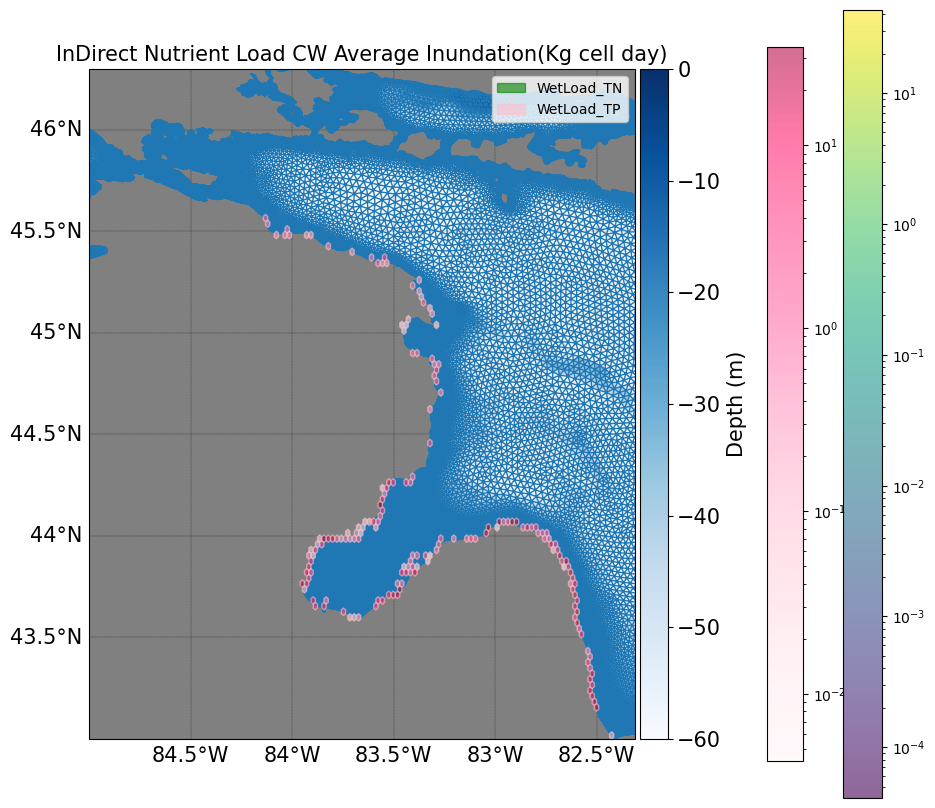

In [44]:
plot_combined_wetload_distribution(
    merged_data=merged_data_avg,
    grid_metrics_file_name=grid_metrics_file_name,
    extents=extents,
    cmap_tn=green_cmap,  # Colormap for nitrogen
    cmap_tp=pink_cmap,  # Colormap for phosphorus
    font_size=15,
    title="InDirect Nutrient Load CW Average Inundation(Kg cell day)")


## Plot Nitrogen return to Coastal Wetlands

In [75]:
def plot_wetload_distribution_TN(merged_data, grid_metrics_file_name, extents, color_map, font_size=15, title=None):
    """
    Creates a hexbin plot showing the WetLoad_TN_kg2 concentration in coastal wetlands with bathymetry background.

    Parameters:
    - merged_data: DataFrame containing 'longitude', 'latitude', and 'WetLoad_TN_kg2' columns.
    - grid_metrics_file_name: Path to the NetCDF file containing bathymetry data.
    - extents: List defining the geographic extents for plotting [xmin, xmax, ymin, ymax].
    - color_map: Colormap for hexbin particle data.
    - font_size: Integer representing the font size in the plot.
    - title: Optional string to set a custom plot title.

    Returns:
    - None; displays a plot.
    """

    # Collect coordinates and WetLoad_TN_kg2 data for plotting
    all_coords = np.array(list(zip(merged_data['longitude'], merged_data['latitude'])))
    wetload_tn = merged_data[fieldDirectTN].values

    # Create the figure and axis using the FVCOM plotter
    fig, ax = create_figure(figure_size=(26., 26.), projection=ccrs.PlateCarree(), font_size=font_size, bg_color='gray')

    # Load bathymetry data from NetCDF
    with Dataset(grid_metrics_file_name, 'r') as ds:
        bathy = -ds.variables['h'][:]

    # Configure plotter and plot bathymetry
    plotter = FVCOMPlotter(grid_metrics_file_name, geographic_coords=True, font_size=font_size)
    ax, plot = plotter.plot_field(ax, bathy, extents=extents, add_colour_bar=True, cb_label='Depth (m)', vmin=-60., vmax=0., cmap='Blues', zorder=0)
    plotter.draw_grid(ax, linewidth=1.0)

    # Create a hexbin plot where bins reflect WetLoad_TN_kg2 concentration
    hb = ax.hexbin(all_coords[:, 0], all_coords[:, 1], C=wetload_tn, gridsize=50, cmap=color_map, norm=LogNorm(), reduce_C_function=np.sum, zorder=40)

    # Add color bar for WetLoad_TN_kg2 concentration
    cbar = fig.colorbar(hb, ax=ax, pad=0.1)
    cbar.set_label('Annual Indirect Nitrogen Load (kgcelldaya)', fontsize=font_size)

    # Set axis labels and title
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(title if title else 'Indirect Annual Nitrogen Load to Coastal Wetlands with Average Inundation (kg^2/area)', fontsize=font_size)
    plt.savefig(output_path + '/WetLoadDistribution_AvgInun_Nitrogen.png', dpi=300, bbox_inches='tight')
    # Show the plot
    plt.show()


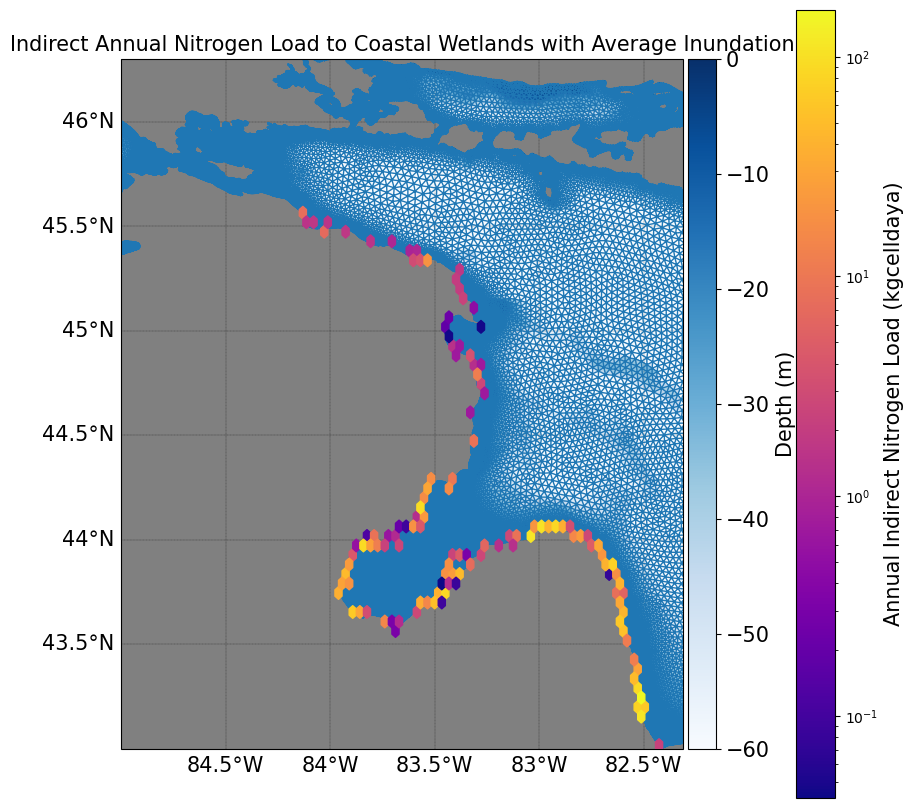

In [76]:
plot_wetload_distribution_TN(
    merged_data=merged_data_avg,
    grid_metrics_file_name= grid_metrics_file_name,
    extents=extents,
    color_map=plasma_cmap,
    font_size=15,
    title='Indirect Annual Nitrogen Load to Coastal Wetlands with Average Inundation'
)

#plt.savefig(output_path + '/WetLoadDistribution_AvgInun.png', dpi=300, bbox_inches='tight')

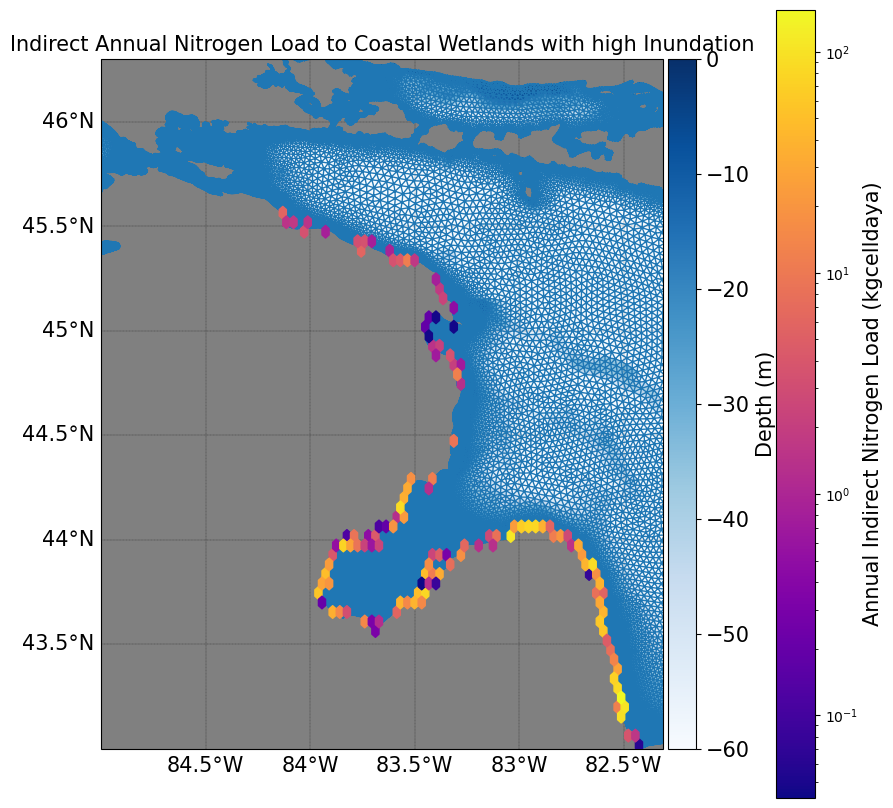

In [77]:
plot_wetload_distribution_TN(
    merged_data=merged_data_high,
    grid_metrics_file_name= grid_metrics_file_name,
    extents=extents,
    color_map=plasma_cmap,
    font_size=15,
    title='Indirect Annual Nitrogen Load to Coastal Wetlands with high Inundation'
)

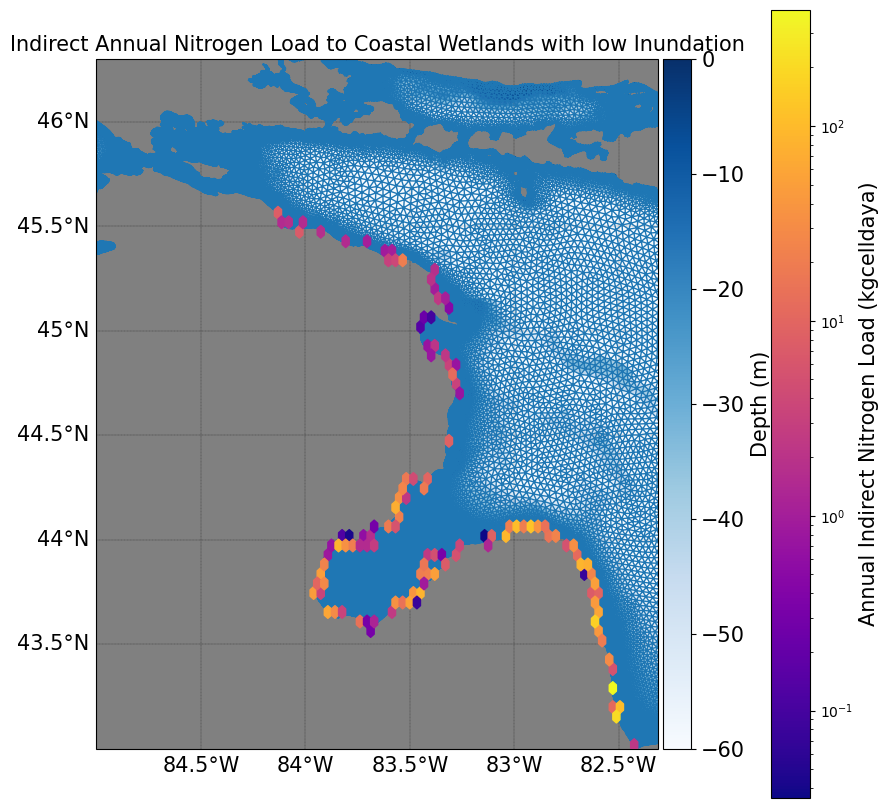

In [78]:
plot_wetload_distribution_TN(merged_data=merged_data_low,
    grid_metrics_file_name= grid_metrics_file_name,
    extents=extents,
    color_map=plasma_cmap,
    font_size=15,
    title='Indirect Annual Nitrogen Load to Coastal Wetlands with low Inundation'
)

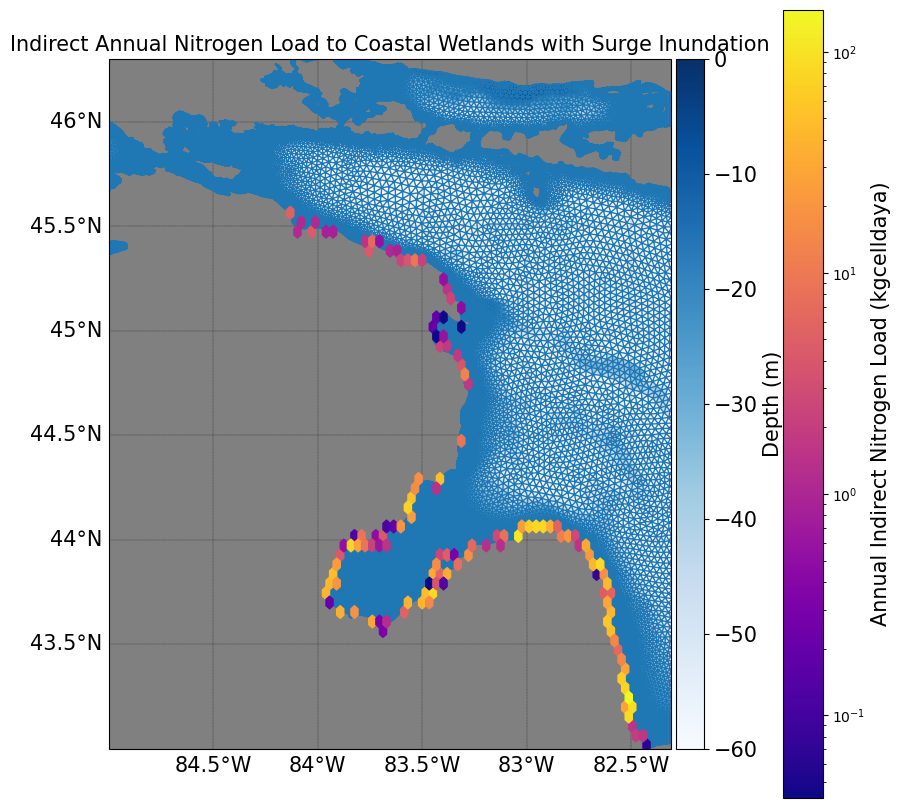

In [79]:
plot_wetload_distribution_TN(merged_data=merged_data_surge, 
    grid_metrics_file_name= grid_metrics_file_name,
    extents=extents,
    color_map=plasma_cmap,
    font_size=15,
    title='Indirect Annual Nitrogen Load to Coastal Wetlands with Surge Inundation'
)

## Plot Phosphorus return to coastal Wetlands 

In [80]:
def plot_wetload_distribution_TP(merged_data, grid_metrics_file_name, extents, colourmap, font_size=15, title=None):
    """
    Creates a hexbin plot showing the WetLoad_TP_kg2 concentration in coastal wetlands with bathymetry background.

    Parameters:
    - merged_data: DataFrame containing 'longitude', 'latitude', and 'WetLoad_TP_kg2' columns.
    - grid_metrics_file_name: Path to the NetCDF file containing bathymetry data.
    - extents: List defining the geographic extents for plotting [xmin, xmax, ymin, ymax].
    - green_cmap: Colormap for hexbin phosphorus load data.
    - font_size: Integer representing the font size in the plot.
    - title: Optional string to set a custom plot title.

    Returns:
    - None; displays a plot.
    """

    # Collect coordinates and WetLoad_TP_kg2 data for plotting
    all_coords = np.array(list(zip(merged_data['longitude'], merged_data['latitude'])))
    wetload_tp = merged_data[fieldDirectTP].values

    # Create the figure and axis using the FVCOM plotter
    fig, ax = create_figure(figure_size=(26., 26.), projection=ccrs.PlateCarree(), font_size=font_size, bg_color='gray')

    # Load bathymetry data from NetCDF
    with Dataset(grid_metrics_file_name, 'r') as ds:
        bathy = -ds.variables['h'][:]

    # Configure plotter and plot bathymetry
    plotter = FVCOMPlotter(grid_metrics_file_name, geographic_coords=True, font_size=font_size)
    ax, plot = plotter.plot_field(ax, bathy, extents=extents, add_colour_bar=True, cb_label='Depth (m)', vmin=-60., vmax=0., cmap='Blues', zorder=0)
    plotter.draw_grid(ax, linewidth=1.0)

    # Create a hexbin plot where bins reflect WetLoad_TP_kg2 concentration
    hb = ax.hexbin(all_coords[:, 0], all_coords[:, 1], C=wetload_tp, gridsize=50, cmap=colourmap, norm=LogNorm(), reduce_C_function=np.sum, zorder=40)

    # Add color bar for WetLoad_TP_kg2 concentration
    cbar = fig.colorbar(hb, ax=ax, pad=0.1)
    cbar.set_label('Indirect Phosphorus Load (kg^2 per area)', fontsize=font_size)

    # Set axis labels and title
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(title if title else 'Indirect Annual Phosphorus Load to Coastal Wetlands with Average Inundation (kg^2/area)', fontsize=font_size, pad=20)
    plt.savefig(output_path + '/WetLoadDistribution_AvgInun_ph.png', dpi=300, bbox_inches='tight')
    # Show the plot
    plt.show()


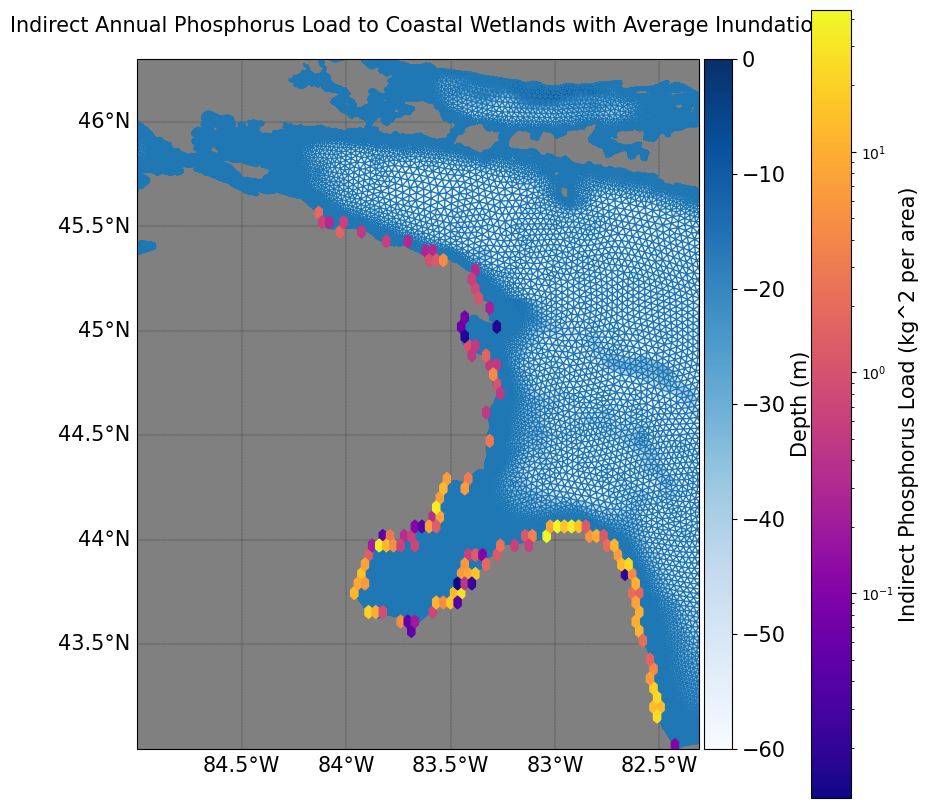

In [81]:
plot_wetload_distribution_TP(
    merged_data=merged_data_avg,
    grid_metrics_file_name = grid_metrics_file_name,
    extents=extents,
    colourmap=plasma_cmap,
    font_size=15,
    title='Indirect Annual Phosphorus Load to Coastal Wetlands with Average Inundation'
)


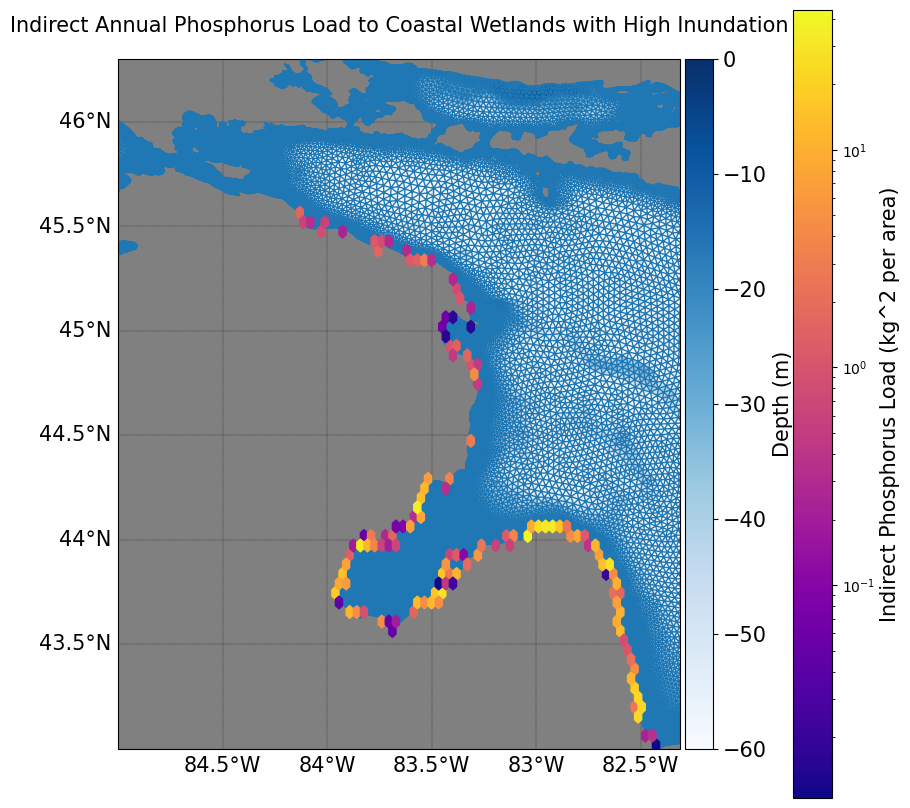

In [82]:
plot_wetload_distribution_TP(
    merged_data=merged_data_high,
    grid_metrics_file_name = grid_metrics_file_name,
    extents=extents,
    colourmap=plasma_cmap,
    font_size=15,
    title='Indirect Annual Phosphorus Load to Coastal Wetlands with High Inundation'
)   